In [1]:
import os
import numpy as np
import mxnet as mx
from utils import check_dir
from memory import Memory
from utils import create_input, translate_state
from evaluation_mxnet import evaluate
from mxnet import gluon, nd, autograd
from environments.SimpleEnv import SimpleEnv

In [2]:
# training cases
order = "model_test"
# batch size
batch_size = 1024
# agent view
agent_view = 5
map_size = 20
# action max
action_max = 3
# learning rate
model_save = "./model_save/"
lr = 0.001
num_episode = 1000000
# start play
replay_start = 10000
# update step
update_step = 1000
# gamma in q-loss calculation
gamma = 0.99
# memory pool size
memory_length = 500000
# file to save train log
summary = "./{}_Reward.csv".format(order)
eval_statistics = "./{}_CSV.csv".format(order)
# the number of step it take to linearly anneal the epsilon to it min value
annealing_end = 200000
# min level of stochastically of policy (epsilon)-greedy
epsilon_min = 0.2
# temporary files
temporary_model = "./{}/{}.params".format(model_save, order)
temporary_pool = "./{}/{}.pool".format(model_save, order)

In [3]:
if os.path.exists(summary):
    os.remove(summary)
ctx = mx.gpu()
for i in ["model_save", "data_save"]:
    check_dir(i)

In [4]:
# build models
from model.simple_stack import SimpleStack
online_model = SimpleStack()
offline_model = SimpleStack()
online_model.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx)
offline_model.collect_params().initialize(mx.init.MSRAPrelu(), ctx=ctx)
offline_model.collect_params().zero_grad()

In [5]:
# create env
env = SimpleEnv(display=False, agent_view=agent_view, map_size=map_size)
memory_pool = Memory(memory_length)
annealing = 0
total_reward = np.zeros(num_episode)
loss_func = gluon.loss.L2Loss()
trainer = gluon.Trainer(offline_model.collect_params(), 'adam', {'learning_rate': lr})

In [6]:
_print = True
best = 0
_all = 0
_update = 0
for epoch in range(num_episode):
    env.reset_env()
    finish = 0
    cum_clipped_dr = 0
    if epoch == 51:
        print("Model Structure: ")
        print(offline_model)
    if sum(env.step_count) > replay_start and _print:
        print('annealing and learning are started')
        _print = False
    while not finish:
        _all += 1
        if sum(env.step_count) > replay_start:
            annealing += 1
        eps = np.maximum(1 - sum(env.step_count) / annealing_end, epsilon_min)
        if np.random.random() < eps:
            by = "Random"
            action = np.random.randint(0, action_max)
        else:
            by = "Model"
            data = create_input([translate_state(env.map.state())])
            data = [nd.array(i, ctx=ctx) for i in data]
            action = offline_model(data)
            action = int(nd.argmax(action, axis=1).asnumpy()[0])
        old, new, reward_get, finish = env.step(action)
        memory_pool.add(old, new, action, reward_get, finish)
        if finish and epoch > 50:
            cum_clipped_dr += sum(env.detect_rate[-1]) / 2
            dr_50 = float(np.mean(env.detect_rate[-50:]))
            dr_all = float(np.mean(env.detect_rate))
            ar_50 = float(np.mean([np.mean(x) if x != [] else ar_50 for x in env.rewards][-50:]))
            ar_all = float(np.mean([np.mean(x) if x != [] else ar_all for x in env.rewards]))
            if epoch % 50 == 0:
                text = "DR: %f(50), %f(all), AR: %f(50), %f(all) eps: %f" % (dr_50, dr_all, ar_50, ar_all, eps)
                print(text)
                with open(summary, "a") as f:
                    f.writelines(text + "\n")
            # save model and replace online model each update_step
            if annealing > replay_start and annealing % update_step == 0:
                offline_model.save_parameters(temporary_model)
                online_model.load_parameters(temporary_model, ctx)
                if best < dr_all:
                    best = dr_all
                    offline_model.save_parameters(temporary_model+ ".best")
    #  train every 2 epoch
    if annealing > replay_start and epoch % 2 == 0:
        _update += 1
        # Sample random mini batch of transitions
        if len(memory_pool.memory) > batch_size:
            bz = batch_size
        else:
            bz = len(memory_pool.memory)
        for_train = memory_pool.next_batch(bz)
        with autograd.record(train_mode=True):
            _state =[nd.array(i, ctx=ctx) for i in for_train["state"]]
            _state_next = [nd.array(i, ctx=ctx) for i in for_train["state_next"]]
            _finish = nd.array(for_train["finish"], ctx=ctx)
            _action = nd.array(for_train["action"], ctx=ctx)
            _reward = nd.array(for_train["reward"], ctx=ctx)
            q_sp = nd.max(online_model(_state_next), axis=1)
            q_sp = q_sp * (nd.ones(bz, ctx=ctx) - _finish)
            q_s_array = offline_model(_state)
            q_s = nd.pick(q_s_array, _action, 1)
            loss = nd.mean(loss_func(q_s, (_reward + gamma * q_sp)))
        loss.backward()
        trainer.step(bz)
    total_reward[int(epoch) - 1] = cum_clipped_dr

Model Structure: 
SimpleStack(
  (view): ViewBlock(
    (0): Conv2D(2 -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2D(64 -> 128, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (2): Conv2D(128 -> 128, kernel_size=(2, 2), stride=(1, 1), bias=False)
  )
  (map): MapBlock(
    (0): Conv2D(1 -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=avg, layout=NCHW)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
  (memory): MemoryBlock(
    (0): Conv2D(1 -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): AvgPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_typ

DR: 0.280991(50), 0.274273(all), AR: -0.799389(50), -0.645517(all) eps: 0.200000
DR: 0.390099(50), 0.275604(all), AR: -0.510170(50), -0.643961(all) eps: 0.200000
DR: 0.376472(50), 0.276750(all), AR: -0.600954(50), -0.643473(all) eps: 0.200000
DR: 0.270157(50), 0.276676(all), AR: -0.811100(50), -0.645356(all) eps: 0.200000
DR: 0.335434(50), 0.277329(all), AR: -0.609985(50), -0.644963(all) eps: 0.200000
DR: 0.339760(50), 0.278015(all), AR: -0.718090(50), -0.645766(all) eps: 0.200000
DR: 0.273375(50), 0.277964(all), AR: -0.821097(50), -0.647672(all) eps: 0.200000
DR: 0.345299(50), 0.278688(all), AR: -0.530795(50), -0.646415(all) eps: 0.200000
DR: 0.358038(50), 0.279532(all), AR: -0.576932(50), -0.645676(all) eps: 0.200000
DR: 0.402327(50), 0.280824(all), AR: -0.432608(50), -0.643434(all) eps: 0.200000
DR: 0.364544(50), 0.281696(all), AR: -0.652765(50), -0.643531(all) eps: 0.200000
DR: 0.320920(50), 0.282100(all), AR: -0.736229(50), -0.644486(all) eps: 0.200000
DR: 0.397246(50), 0.283275(a

DR: 0.341333(50), 0.314523(all), AR: -0.658169(50), -0.621572(all) eps: 0.200000
DR: 0.363588(50), 0.314783(all), AR: -0.559536(50), -0.621244(all) eps: 0.200000
DR: 0.392269(50), 0.315191(all), AR: -0.511538(50), -0.620667(all) eps: 0.200000
DR: 0.332077(50), 0.315279(all), AR: -0.606998(50), -0.620595(all) eps: 0.200000
DR: 0.363167(50), 0.315528(all), AR: -0.523442(50), -0.620089(all) eps: 0.200000
DR: 0.370912(50), 0.315815(all), AR: -0.660359(50), -0.620298(all) eps: 0.200000
DR: 0.371487(50), 0.316102(all), AR: -0.547089(50), -0.619921(all) eps: 0.200000
DR: 0.368279(50), 0.316370(all), AR: -0.688992(50), -0.620275(all) eps: 0.200000
DR: 0.334043(50), 0.316460(all), AR: -0.713126(50), -0.620748(all) eps: 0.200000
DR: 0.317235(50), 0.316464(all), AR: -0.674813(50), -0.621023(all) eps: 0.200000
DR: 0.337716(50), 0.316571(all), AR: -0.569802(50), -0.620764(all) eps: 0.200000
DR: 0.305960(50), 0.316518(all), AR: -0.796004(50), -0.621645(all) eps: 0.200000
DR: 0.385985(50), 0.316865(a

DR: 0.400606(50), 0.329660(all), AR: -0.400519(50), -0.606715(all) eps: 0.200000
DR: 0.354208(50), 0.329745(all), AR: -0.661806(50), -0.606904(all) eps: 0.200000
DR: 0.354427(50), 0.329829(all), AR: -0.620443(50), -0.606950(all) eps: 0.200000
DR: 0.406687(50), 0.330092(all), AR: -0.543963(50), -0.606735(all) eps: 0.200000
DR: 0.312880(50), 0.330033(all), AR: -0.645227(50), -0.606866(all) eps: 0.200000
DR: 0.389687(50), 0.330235(all), AR: -0.490230(50), -0.606471(all) eps: 0.200000
DR: 0.353180(50), 0.330313(all), AR: -0.459647(50), -0.605975(all) eps: 0.200000
DR: 0.355415(50), 0.330397(all), AR: -0.675664(50), -0.606210(all) eps: 0.200000
DR: 0.307362(50), 0.330320(all), AR: -0.677723(50), -0.606449(all) eps: 0.200000
DR: 0.396563(50), 0.330542(all), AR: -0.452993(50), -0.605936(all) eps: 0.200000
DR: 0.382715(50), 0.330715(all), AR: -0.384627(50), -0.605199(all) eps: 0.200000
DR: 0.366004(50), 0.330833(all), AR: -0.556404(50), -0.605037(all) eps: 0.200000
DR: 0.391818(50), 0.331035(a

DR: 0.391012(50), 0.336864(all), AR: -0.541359(50), -0.599036(all) eps: 0.200000
DR: 0.339470(50), 0.336871(all), AR: -0.622081(50), -0.599095(all) eps: 0.200000
DR: 0.393235(50), 0.337014(all), AR: -0.518957(50), -0.598892(all) eps: 0.200000
DR: 0.422307(50), 0.337230(all), AR: -0.475148(50), -0.598578(all) eps: 0.200000
DR: 0.407822(50), 0.337408(all), AR: -0.517452(50), -0.598373(all) eps: 0.200000
DR: 0.369297(50), 0.337488(all), AR: -0.514311(50), -0.598162(all) eps: 0.200000
DR: 0.428644(50), 0.337717(all), AR: -0.437371(50), -0.597758(all) eps: 0.200000
DR: 0.417930(50), 0.337918(all), AR: -0.569152(50), -0.597686(all) eps: 0.200000
DR: 0.401234(50), 0.338076(all), AR: -0.478690(50), -0.597389(all) eps: 0.200000
DR: 0.397062(50), 0.338224(all), AR: -0.542493(50), -0.597252(all) eps: 0.200000
DR: 0.328903(50), 0.338200(all), AR: -0.696671(50), -0.597499(all) eps: 0.200000
DR: 0.363204(50), 0.338262(all), AR: -0.571947(50), -0.597436(all) eps: 0.200000
DR: 0.342356(50), 0.338273(a

KeyboardInterrupt: 

In [8]:
import seaborn

/home/seventheli/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/seventheli/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:>

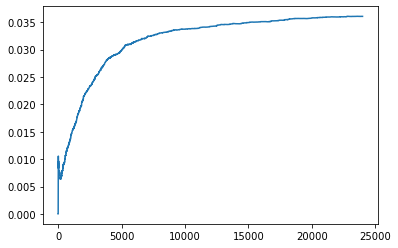

In [31]:
y = []
for i in range(0, len(env.long_term_rewards)):
    y.append(np.mean(env.long_term_rewards[:i]))
seaborn.lineplot(x=range(len(y)), y=y)